In [1]:
import pandas as pd
import os
import sys

import yaml
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.layers import Dense , Dropout , Flatten , Activation , BatchNormalization , Input , Embedding , Dot
from keras.models import Sequential
from keras.utils import to_categorical

from keras.callbacks import EarlyStopping , ModelCheckpoint  , LearningRateScheduler , TensorBoard , CSVLogger
%matplotlib inline


READING CSV

In [2]:
anime_df = pd.read_csv(r"D:\anime_recommend_mlops\archive\animelist.csv" , low_memory=True ,nrows = 50000000 ,  usecols=["user_id","anime_id","rating"] , dtype={'user_id': 'int32', 'anime_id': 'int32', 'rating': 'int8'})

In [3]:
anime_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [4]:
len(anime_df)

50000000

DATA PROCESSING

In [5]:
n_rating = anime_df['user_id'].value_counts().sort_index()

In [6]:
n_rating

user_id
0          74
1         139
2         494
3         358
4         156
         ... 
162164    284
162165    128
162166    241
162168    145
162169    339
Name: count, Length: 149419, dtype: int64

In [7]:
anime_df = anime_df[anime_df["user_id"].isin(n_rating[n_rating >=400].index)].copy()

In [8]:
len(anime_df)

32651275

In [9]:
min_rating = min(anime_df['rating'])

In [10]:
max_rating = max(anime_df['rating'])

In [11]:
min_rating

0

In [12]:
max_rating

10

In [13]:
avg_rating = np.mean(anime_df['rating'])

In [14]:
avg_rating

np.float64(4.033823640883855)

FEATURE SCALING

In [15]:
anime_df["rating"] = anime_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(float)

In [16]:
avg_rating = np.mean(anime_df['rating'])

In [17]:
avg_rating

np.float64(0.4033823640883852)

In [18]:
anime_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [19]:
anime_df.duplicated().sum()

np.int64(1)

In [20]:
user_ids = anime_df['user_id'].unique().tolist()
print(user_ids)

[2, 6, 12, 16, 17, 19, 21, 41, 42, 44, 47, 53, 55, 60, 66, 73, 74, 85, 89, 90, 94, 98, 102, 108, 111, 112, 120, 121, 122, 135, 145, 146, 147, 153, 155, 156, 172, 174, 184, 190, 193, 194, 198, 204, 205, 209, 214, 219, 222, 227, 228, 235, 238, 240, 243, 248, 251, 252, 257, 264, 267, 272, 274, 275, 284, 285, 286, 290, 291, 293, 300, 301, 306, 308, 310, 313, 314, 316, 320, 321, 324, 325, 326, 327, 330, 336, 340, 345, 346, 349, 350, 366, 367, 371, 372, 375, 381, 382, 386, 389, 398, 405, 406, 413, 414, 418, 423, 426, 428, 431, 432, 436, 437, 438, 440, 442, 444, 445, 446, 455, 457, 459, 464, 467, 468, 469, 478, 481, 483, 484, 486, 493, 498, 500, 516, 517, 519, 524, 526, 529, 531, 538, 542, 547, 549, 559, 563, 564, 566, 569, 571, 577, 590, 593, 596, 601, 603, 608, 613, 614, 617, 620, 629, 631, 639, 642, 643, 644, 649, 652, 655, 656, 662, 664, 673, 674, 680, 681, 683, 686, 689, 694, 699, 711, 713, 714, 716, 719, 725, 728, 730, 731, 732, 734, 745, 746, 748, 753, 760, 764, 770, 774, 776, 778, 779

In [21]:
user2user_encoded = {x:i for i , x in enumerate(user_ids)}

In [22]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [23]:
user2user_decoded = { i : x for x , i in enumerate(user_ids)}

In [24]:
user2user_decoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [25]:
n_users = len(user2user_decoded)

In [26]:
anime_df["user"] = anime_df["user_id"].map(user2user_encoded)

In [27]:
anime_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [28]:
anime_ids = anime_df['anime_id'].unique().tolist()

In [29]:
anime2anime_encoded = { x : i for i , x in enumerate(anime_ids)}

In [30]:
anime2anime_decoded = { i:x for x , i in enumerate(anime_ids)}

In [31]:
n_anime = len(anime2anime_decoded)

In [32]:
anime_df["anime"] = anime_df["anime_id"].map(anime2anime_encoded)

In [33]:
anime_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [34]:
anime_df = anime_df.sample(frac=1 , random_state=43).reset_index(drop=True)

SPLITING DATA

In [35]:
X = anime_df[["user","anime"]].values
y = anime_df["rating"]

In [36]:
test_size = 1000
train_indices = anime_df.shape[0]-test_size

In [37]:
X_train, X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [38]:
len(X)

32651275

In [39]:
len(X_test)

1000

In [40]:
X_train_array= [X_train[:,0] , X_train[:,1]]
X_test_array = [X_test[:,0] , X_test[:,1]]

MODEL ARCHITECHTURE

In [41]:
def Recommender():
    embedding_size = 128

    user = Input(name="user", shape=[1])
    user_embedding = Embedding(
        name="user_embedding",   # FIXED
        input_dim=n_users,
        output_dim=embedding_size
    )(user)

    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(
        name="anime_embedding",  # FIXED
        input_dim=n_anime,
        output_dim=embedding_size
    )(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)(
        [user_embedding, anime_embedding]
    )
    x = Flatten()(x)
    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(
        loss="binary_crossentropy",
        metrics=["mae", "mse"],
        optimizer="Adam"
    )

    return model


In [42]:
model = Recommender()

In [43]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  5,369,088 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,247,424 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,616,518 (29.05 MB)

 Trainable params: 7,616,516 (29.05 MB)

 Non-trainable params: 2 (8.00 B)

In [44]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epoch = 5
sustain_epoch = 0 
exp_decay = 0.8

def lr_fn(epoch):
    if epoch<ramup_epoch:
        return (max_lr-start_lr)/ramup_epoch*epoch +start_lr

    elif epoch  < ramup_epoch+sustain_epoch:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay **(epoch-ramup_epoch-sustain_epoch)+min_lr

In [45]:
lr_callback = LearningRateScheduler( lambda epoch: lr_fn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint( filepath = checkpoint_filepath , save_weights_only = True , monitor = "val_loss" , mode="min" , save_best_only=True)
early_stopping = EarlyStopping(patience=3 , monitor="val_loss" , mode="min" , restore_best_weights=True)



In [46]:
my_callbacks = [lr_callback , model_checkpoint , early_stopping]

In [47]:
history = model.fit(
    x = X_train_array,
    y = y_train , 
    batch_size = batch_size , 
    epochs = 5 , 
    verbose = 1 , 
    validation_data = (X_test_array , y_test) , 
    callbacks = my_callbacks
)

Epoch 1/5
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 506s 151ms/step - loss: 0.7986 - mae: 0.3842 - mse: 0.1986 - val_loss: 0.7900 - val_mae: 0.3811 - val_mse: 0.1924 - learning_rate: 1.0000e-05
Epoch 2/5
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 502s 153ms/step - loss: 0.7809 - mae: 0.3796 - mse: 0.1920 - val_loss: 0.7737 - val_mae: 0.3780 - val_mse: 0.1864 - learning_rate: 1.8000e-05
Epoch 3/5
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 501s 152ms/step - loss: 0.7404 - mae: 0.3649 - mse: 0.1756 - val_loss: 0.7121 - val_mae: 0.3515 - val_mse: 0.1603 - learning_rate: 2.6000e-05
Epoch 4/5
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 489s 149ms/step - loss: 0.6330 - mae: 0.3111 - mse: 0.1291 - val_loss: 0.6069 - val_mae: 0.2917 - val_mse: 0.1142 - learning_rate: 3.4000e-05
Epoch 5/5
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 495s 151ms/step - loss: 0.5716 - mae: 0.2731 - mse: 0.1024 - val_loss: 0.5705 - val_mae: 0.2649 - val_mse: 0.0990 - learning_rate: 4.2000e-05


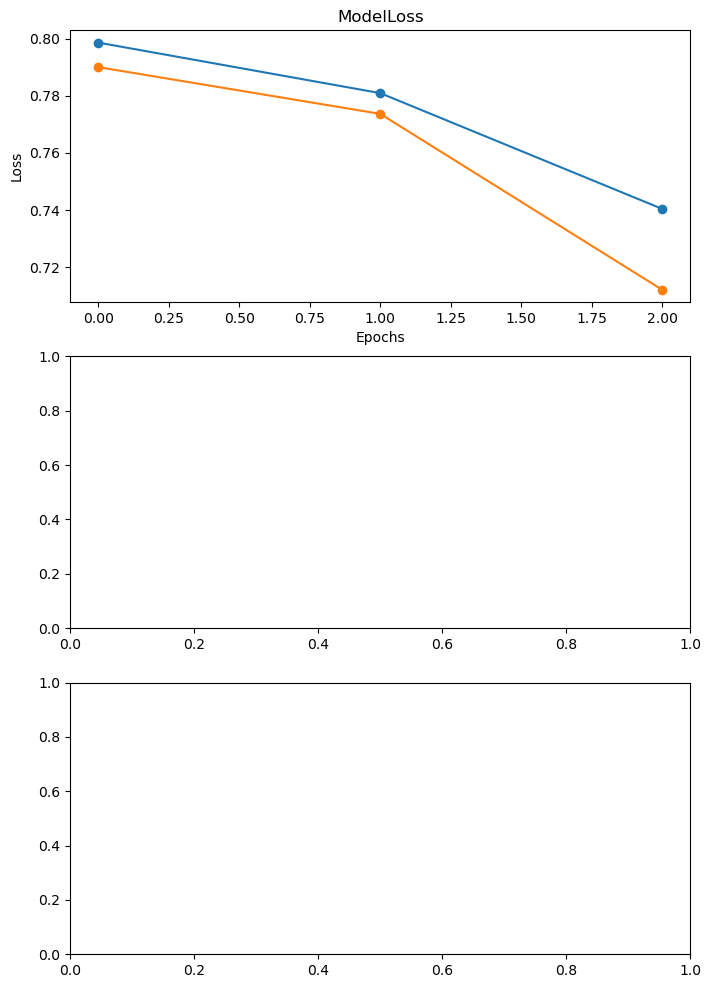

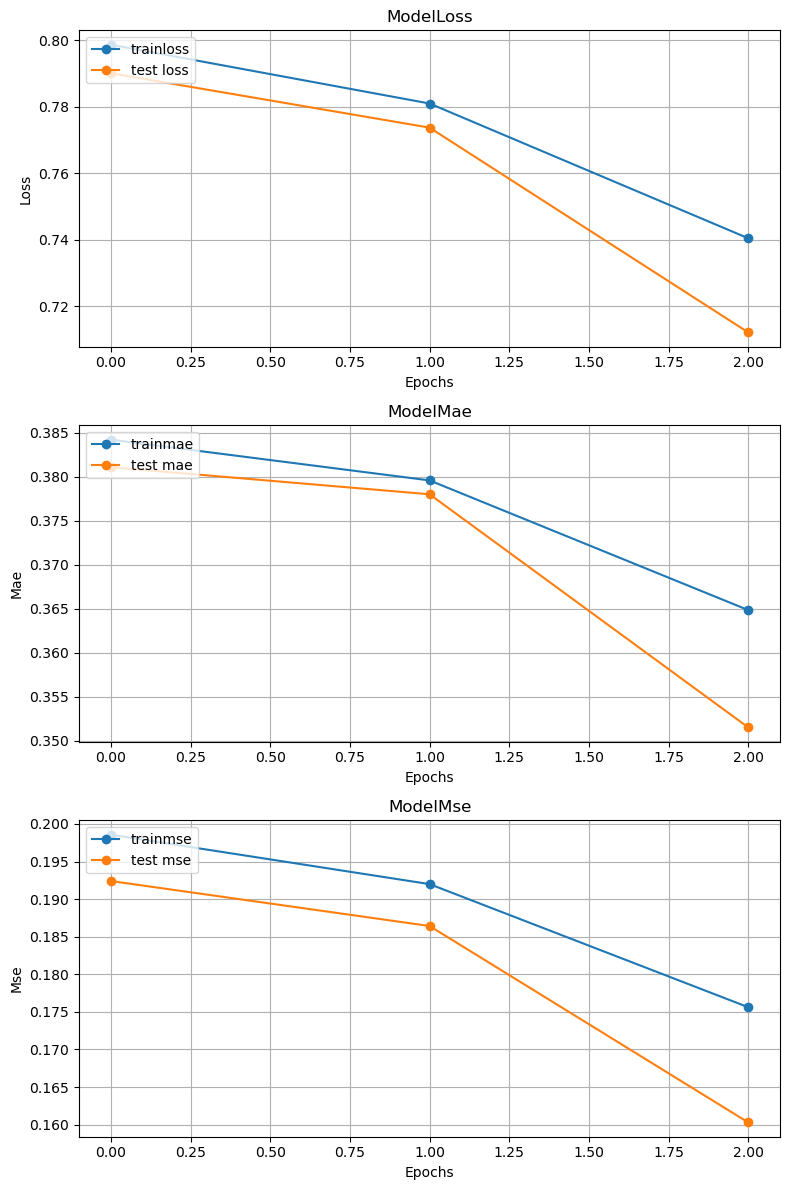

In [49]:
metrics = ["loss" , "mae" , "mse"]
fig , axes = plt.subplots(len(metrics) , 1 , figsize = (8 , len(metrics)*4))

for i , metrics in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metrics][0:-2] , marker = "o" , label=f"train{metrics}")
    ax.plot(history.history[f"val_{metrics}"][0:-2] , marker="o" , label=f"test {metrics}")
    ax.set_title(f"Model{metrics.capitalize()}")
    ax.set_ylabel(metrics.capitalize())
    ax.set_xlabel("Epochs")
    ax.legend(loc = "upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()